## All required imports

In [1]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp
from datetime import date

DEFAULT_X = 8.0
DEFAULT_Y = 0.0

## System description
We will simulate a water-tank level controller. The model will control the input voltage of the inflow pump, so it regulates the level inside the tank.

The level in the tank is described as:

$$H_{t+1} = H_{t} + \Delta t * \frac{P-Q}{A}$$

Where:

$$P = bV$$
$$Q = a\sqrt{H}$$

We define our reward function as:
$$r = -|H-\hat{H}|^{2}$$

We are also testing with a percent difference function:

$$r = -\frac{|H-\hat{H}|}{\hat{H}}

## Create custom environment

In [2]:
class WaterTankEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    @property
    def td(self):
        if self._td is None:
            self._td = WaterTankEnv.gen_params(batch_size=[1])
        
        return self._td

    # Static method to generate default values for parameters
    @staticmethod
    def gen_params(A = 20.0, a = 2.0, b = 5.0, batch_size=None) -> TensorDictBase:
        """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
        if batch_size is None:
            batch_size = []
        td = TensorDict(
            {
                "params": TensorDict(
                    {
                        "max_voltage": 120.0,
                        "min_voltage": 0.0,
                        "max_H": 15.0,
                        "min_H": 1e-6,
                        "H_hat": 10.0, # setpoint
                        "A": A,
                        "a": a,
                        "b": b,
                        "dt": 0.05,
                        "P_hat": 0.0
                    },
                    [],
                )
            },
            [],
        )
        if batch_size:
            td = td.expand(batch_size).contiguous()
        return td
    
    # Define the cost function here
    @staticmethod
    def cost(tensordict: TensorDict):
        H = tensordict["H"]
        H_hat = tensordict["params", "H_hat"]

        return torch.abs(H - H_hat)/H_hat


    # Step method
    @staticmethod
    def _step(tensordict):
        H = tensordict["H"]

        # Pump and tank parameters
        A = tensordict["params", "A"] # area of tank
        b = tensordict["params", "b"] # parameter of pump
        a = tensordict["params", "a"] # parameter of output valve
        H_hat = tensordict["params", "H_hat"] # setpoint
        P_hat = tensordict["params", "P_hat"] # disturbance

        dt = tensordict["params", "dt"]
        u = tensordict["action"].squeeze(-1)
        u = u.clamp(tensordict["params", "min_voltage"], tensordict["params", "max_voltage"])
        
        costs = WaterTankEnv.cost(tensordict)
        #costs = torch.abs(H - H_hat)/H_hat

        P = b*u + P_hat
        Q = a*torch.sqrt(H)

        # Compute new state using 4th-order Runge-Kutta method
        # k1 = (P-Q)/A
        # k2 = (P-Q)/A + dt*k1/2.0
        # k3 = (P-Q)/A + dt*k2/2.0
        # k4 = (P-Q)/A + dt*k3

        # new_H = H + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

        new_H = (
            H + dt * (P - Q)/A
        )
        #print(new_H)

        # Clamp between its range [min_H, max_H]
        new_H = new_H.clamp(
            tensordict["params", "min_H"], tensordict["params", "max_H"]
        )

        reward = -costs.view(*tensordict.shape, 1)
        done = torch.zeros_like(reward, dtype=torch.bool)
        out = TensorDict(
            {
                "H": new_H,
                "params": tensordict["params"],
                "reward": reward,
                "done": done,
                "reward": -costs
            },
            tensordict.shape,
        )
        return out
    
    def _reset(self, tensordict):
        if tensordict is None or tensordict.is_empty():
            # if no ``tensordict`` is passed, we generate a single set of hyperparameters
            # Otherwise, we assume that the input ``tensordict`` contains all the relevant
            # parameters to get started.
            tensordict = self.gen_params(batch_size=self.batch_size)

        high_H = torch.tensor(DEFAULT_X, device = self.device)
        low_H = torch.tensor(1e-6, device = self.device)

        # for non batch-locked environments, the input ``tensordict`` shape dictates the number
        # of simulators run simultaneously. In other contexts, the initial
        # random state's shape will depend upon the environment batch-size instead.

        H = (
            torch.rand(tensordict.shape, generator = self.rng, device = self.device)
            * (high_H - low_H) + low_H
        )

        out = TensorDict(
            {
                "H": H,
                "params": tensordict["params"],
            },
            batch_size=tensordict.shape,
        )
        return out
    
    def _make_spec(self, td_params):
        # Under the hood, this will populate self.output_spec["observation"]
        self.observation_spec = CompositeSpec(
            H=BoundedTensorSpec(
                low=td_params["params", "min_H"],
                high=td_params["params", "max_H"],
                shape=(),
                dtype=torch.float32,
            ),
            # we need to add the ``params`` to the observation specs, as we want
            # to pass it at each step during a rollout
            params=make_composite_from_td(td_params["params"]),
            shape=(),
        )
        # since the environment is stateless, we expect the previous output as input.
        # For this, ``EnvBase`` expects some state_spec to be available
        self.state_spec = self.observation_spec.clone()
        # action-spec will be automatically wrapped in input_spec when
        # `self.action_spec = spec` will be called supported
        self.action_spec = BoundedTensorSpec(
            low=td_params["params", "min_voltage"],
            high=td_params["params", "max_voltage"],
            shape=(1,),
            dtype=torch.float32,
        )
        self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))

    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng


def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite
        

    # Helpers: _make_step and gen_params
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

## Test env

In [3]:
env = WaterTankEnv()
check_env_specs(env)

2024-03-20 11:26:59,805 [torchrl][INFO] check_env_specs succeeded!


Take a brief look at out specs

In [4]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    H: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        max_voltage: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        min_voltage: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        max_H: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=contin

In [5]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        H: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                A: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                H_hat: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                P_hat: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                a: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                b: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_H: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_

In [6]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        H: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                H: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        A: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        H_hat: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        P_hat: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        a: Tenso

In [7]:
env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["H"],
        in_keys_inv=["H"],
    ),
)

In [8]:
cat_transform = CatTensors(
    in_keys=["H"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)

In [9]:
check_env_specs(env)

2024-03-20 11:26:59,875 [torchrl][INFO] check_env_specs succeeded!


In [10]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        H: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                H: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        A: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        H_hat: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),

In [11]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        H: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                A: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                H_hat: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                P_hat: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                a: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                b: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_sha

In [12]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        H: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                H: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        A: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        H_hat: Tensor(shape=torch.Size([10, 3]), device=cpu, dtyp

In [13]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

c:\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

In [15]:
batch_size = 32
T_max = 50_000
pbar = tqdm.tqdm(range(T_max // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(500, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    logs["state_value"].append(rollout["H"])
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

reward: -0.3350, last reward: -0.1289, gradient norm:  1.507:  28%|██▊       | 434/1562 [07:08<18:33,  1.01it/s] 


KeyboardInterrupt: 

## Save Model

In [ ]:
import os
torch.save(policy, f"model_{date.today()}.pt")

## Now let's test the model

In [ ]:
# Load model
policy = torch.load(f"model_{date.today()}.pt")

In [ ]:
tf = 200 # seconds
dt = 0.05
N = int(tf // dt)

# Generate parameters
sim_td = WaterTankEnv.gen_params(batch_size = [1])
sim_td = env.reset(sim_td) # System is at it starting point

sim_events = [
    # variable, value, time
    ("H_hat", 20, 50),
    #("P_hat", 37, 100)
]

#H_vals = []
H_ref = []
t_vals = []
H_vals = TensorDict({}, batch_size=[N])
result = TensorDict({}, [N])
for i in range(N):
    ti = i*dt

    # Check events
    for event in sim_events:
        if ti >= event[2]:
            sim_td["params", event[0]] = torch.tensor([event[1]], dtype=torch.float32)

    # Based on current state, get optimal action from policy
    action = policy(sim_td)["action"].squeeze(dim=1) # tensor([value])

    # Assign action to tensordict
    sim_td["action"] = action

    # Make step in simulation with this action value
    sim_td = env.step(sim_td)

    # Get new H
    new_H = sim_td["next", "observation"]
    H_ref = sim_td["params", "H_hat"]

    sim_td = step_mdp(sim_td, keep_other= True) # Remove the "next" td and move its values to the main "td"
    

    #H_vals.append(sim_td["next", "H"].item()) # New H value
    result[i] = TensorDict({
        "H": new_H,
        "H_hat": H_ref,
        "action": action
        }, [1])
    #H_vals[i] = new_H
    #H_ref.append(sim_td["params", "H_hat"].item())
    t_vals.append(ti)
    



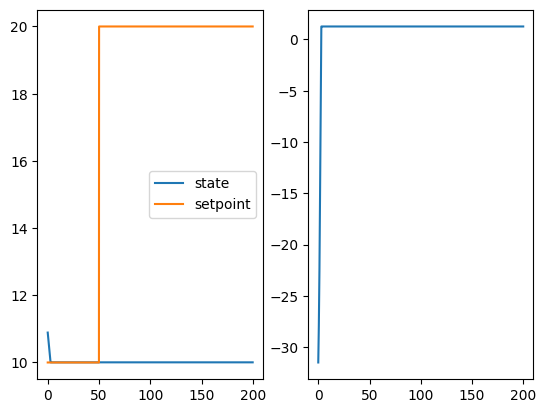

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(t_vals, result["H"].squeeze(dim=1).detach().numpy(), label = 'state')
plt.plot(t_vals, result["H_hat"].squeeze(dim=1).detach().numpy(), label = 'setpoint')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t_vals, result["action"].squeeze(dim=1).detach().numpy())
plt.show()

In [ ]:
sim_td["params", "H_hat"]

tensor([20.])

In [ ]:
sim_td["observation"]

tensor([[10.0043]], grad_fn=<CatBackward0>)

In [ ]:
nn_out = policy(sim_td)
nn_out

TensorDict(
    fields={
        H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                A: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                H_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                P_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                a: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                b: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                dt: Ten

In [ ]:
sim_td["action"] = nn_out["action"]
sim_td

TensorDict(
    fields={
        H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                A: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                H_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                P_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                a: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                b: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                dt: Ten

In [ ]:
sim_td = WaterTankEnv.gen_params(batch_size = [1])
sim_td = env.reset(sim_td)
action = policy(sim_td)["action"].squeeze(dim=1)
sim_td["action"] = action
out = env.step(sim_td)
out


TensorDict(
    fields={
        H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        A: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                        H_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                        P_hat: Tensor

In [ ]:
new_sim_td = env.step(sim_td)
new_sim_td

TensorDict(
    fields={
        H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                H: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        A: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                        H_hat: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                        P_hat: Tensor

In [ ]:
new_sim_td["next", "observation"]

tensor([[12.8610]], grad_fn=<CatBackward0>)

In [ ]:
env.action_spec.rand()

tensor([3.4822])

In [ ]:
action

tensor([-39.3415], grad_fn=<SqueezeBackward1>)